In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [2]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d
csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"

In [3]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [4]:
df = df.sort_values('Date')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [6]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

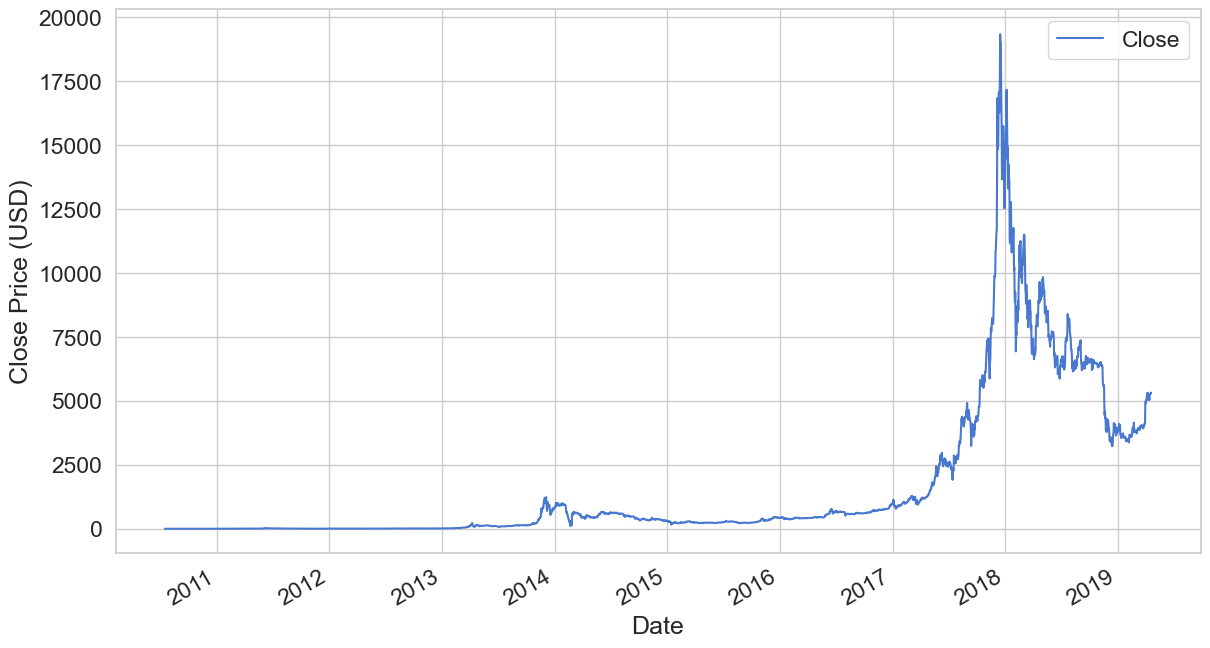

In [7]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [8]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [9]:
scaled_close.shape

(3201, 1)

In [10]:
np.isnan(scaled_close).any()

False

In [11]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [12]:
scaled_close = scaled_close.reshape(-1, 1)

In [13]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [14]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [15]:
X_train.shape

(2945, 99, 1)

In [16]:
X_test.shape

(156, 99, 1)

# Model

In [17]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [18]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

In [19]:
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1
)

Epoch 1/10
42/42 [==============================] - 25s 499ms/step - loss: 0.0020 - val_loss: 0.0135
Epoch 2/10
42/42 [==============================] - 22s 515ms/step - loss: 0.0091 - val_loss: 0.0060
Epoch 3/10
42/42 [==============================] - 19s 458ms/step - loss: 0.0082 - val_loss: 0.0166
Epoch 4/10
42/42 [==============================] - 19s 460ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 5/10
42/42 [==============================] - 20s 466ms/step - loss: 0.0156 - val_loss: 0.0447
Epoch 6/10
42/42 [==============================] - 20s 475ms/step - loss: 0.0023 - val_loss: 0.0108
Epoch 7/10
42/42 [==============================] - 19s 452ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 8/10
42/42 [==============================] - 18s 425ms/step - loss: 0.0118 - val_loss: 0.0601
Epoch 9/10
42/42 [==============================] - 17s 413ms/step - loss: 0.0092 - val_loss: 0.0238
Epoch 10/10
42/42 [==============================] - 18s 423ms/step - loss: 0.0053 - val_lo

In [20]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 78ms/step - loss: 0.0234


0.02342830039560795

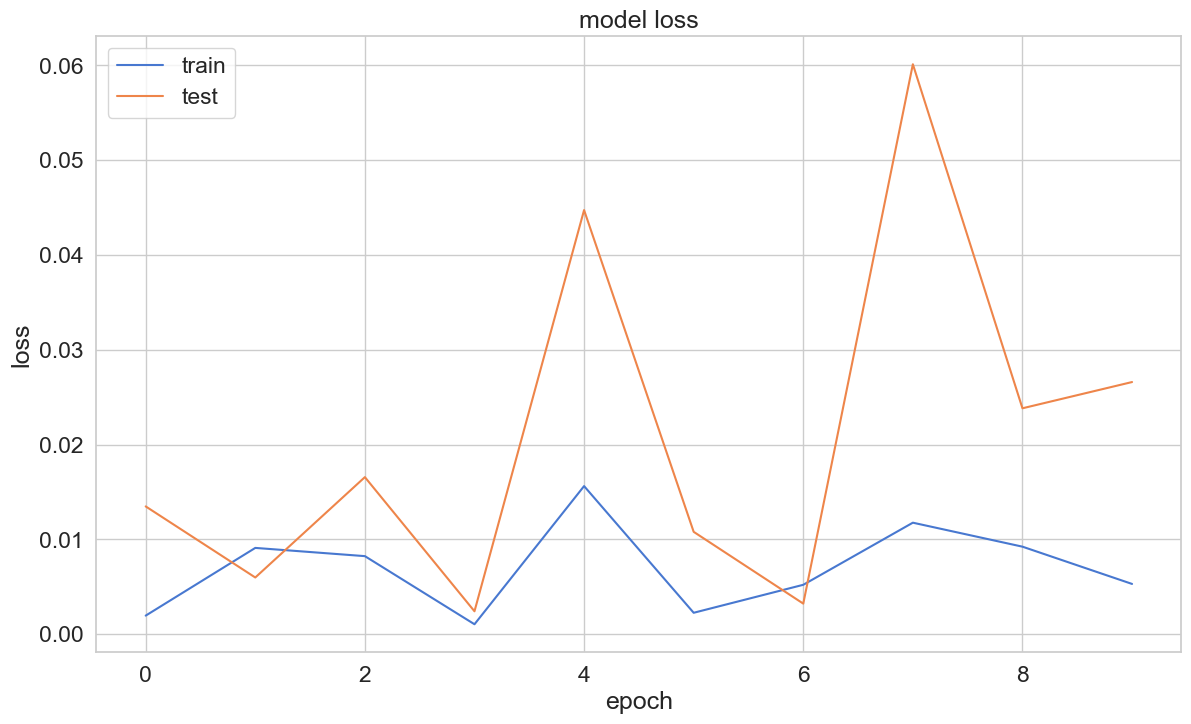

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

5/5 [==============================] - 1s 70ms/step


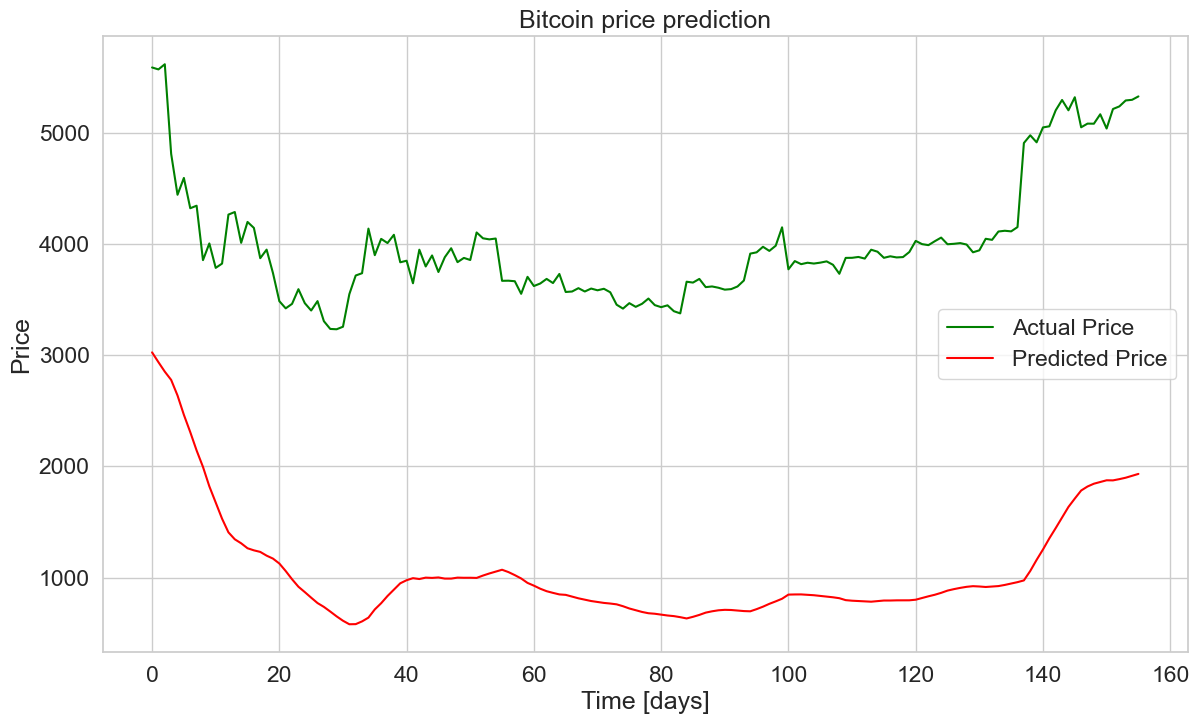

In [22]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')

plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

plt.show();